<a href="https://colab.research.google.com/github/jadechip/cl-demo/blob/main/Chainlink_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Extract, Transform, Load

For the first part of my submission, I've chosen to work with the Ethereum blockchain. 

In order to extract a large amount of data in a scalable and cost-effective manner, I've decided to use Cloud Composer/Apache Airflow to compose a scalable and versatile ETL pipline, in combination with BigQuery as the data warehouse solution of choice. 

For extracting and parsing data from the Ethereum blockchain, I've relied on the excellent [ethereum-etl](https://ethereum-etl.readthedocs.io/en/latest/https://) library.

For the blockchain data itself, I used nodes from multiple service providers such as Infura, Alchemy and Quicknode in order to avoid having to sync from scratch.

```
`# This is formatted as code`
```



This approach is also works for other blockchains.

### Task overview

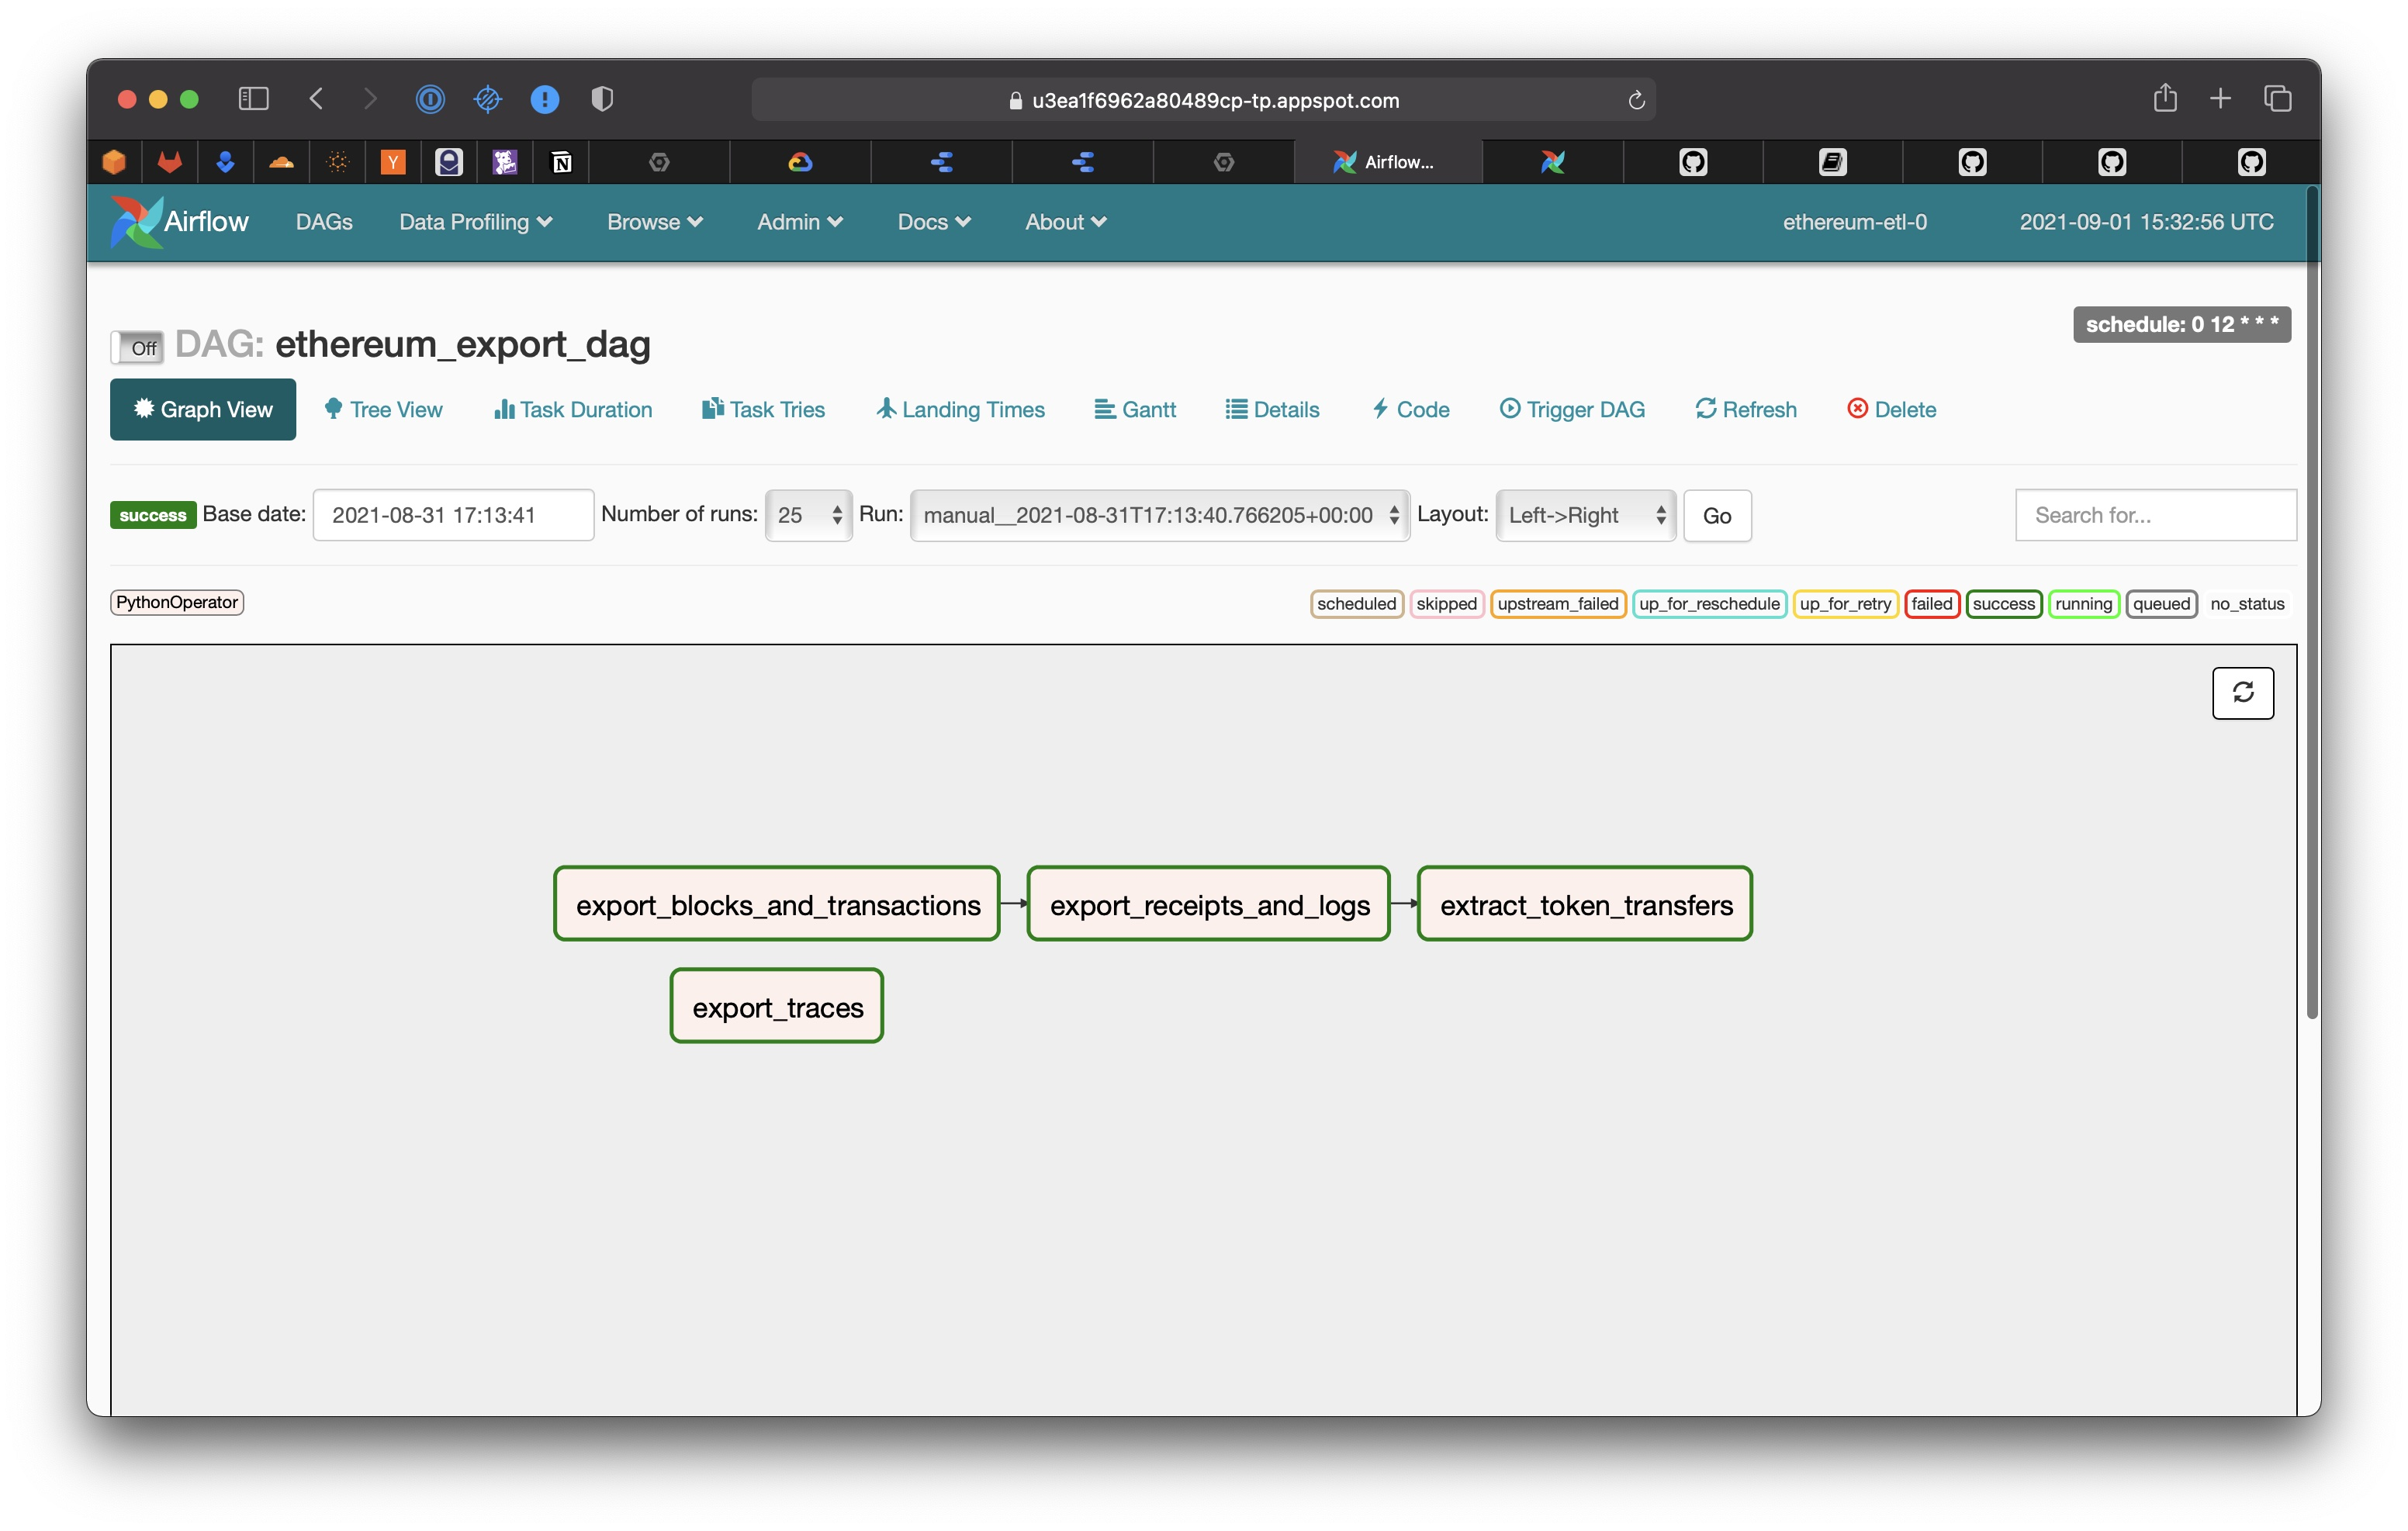

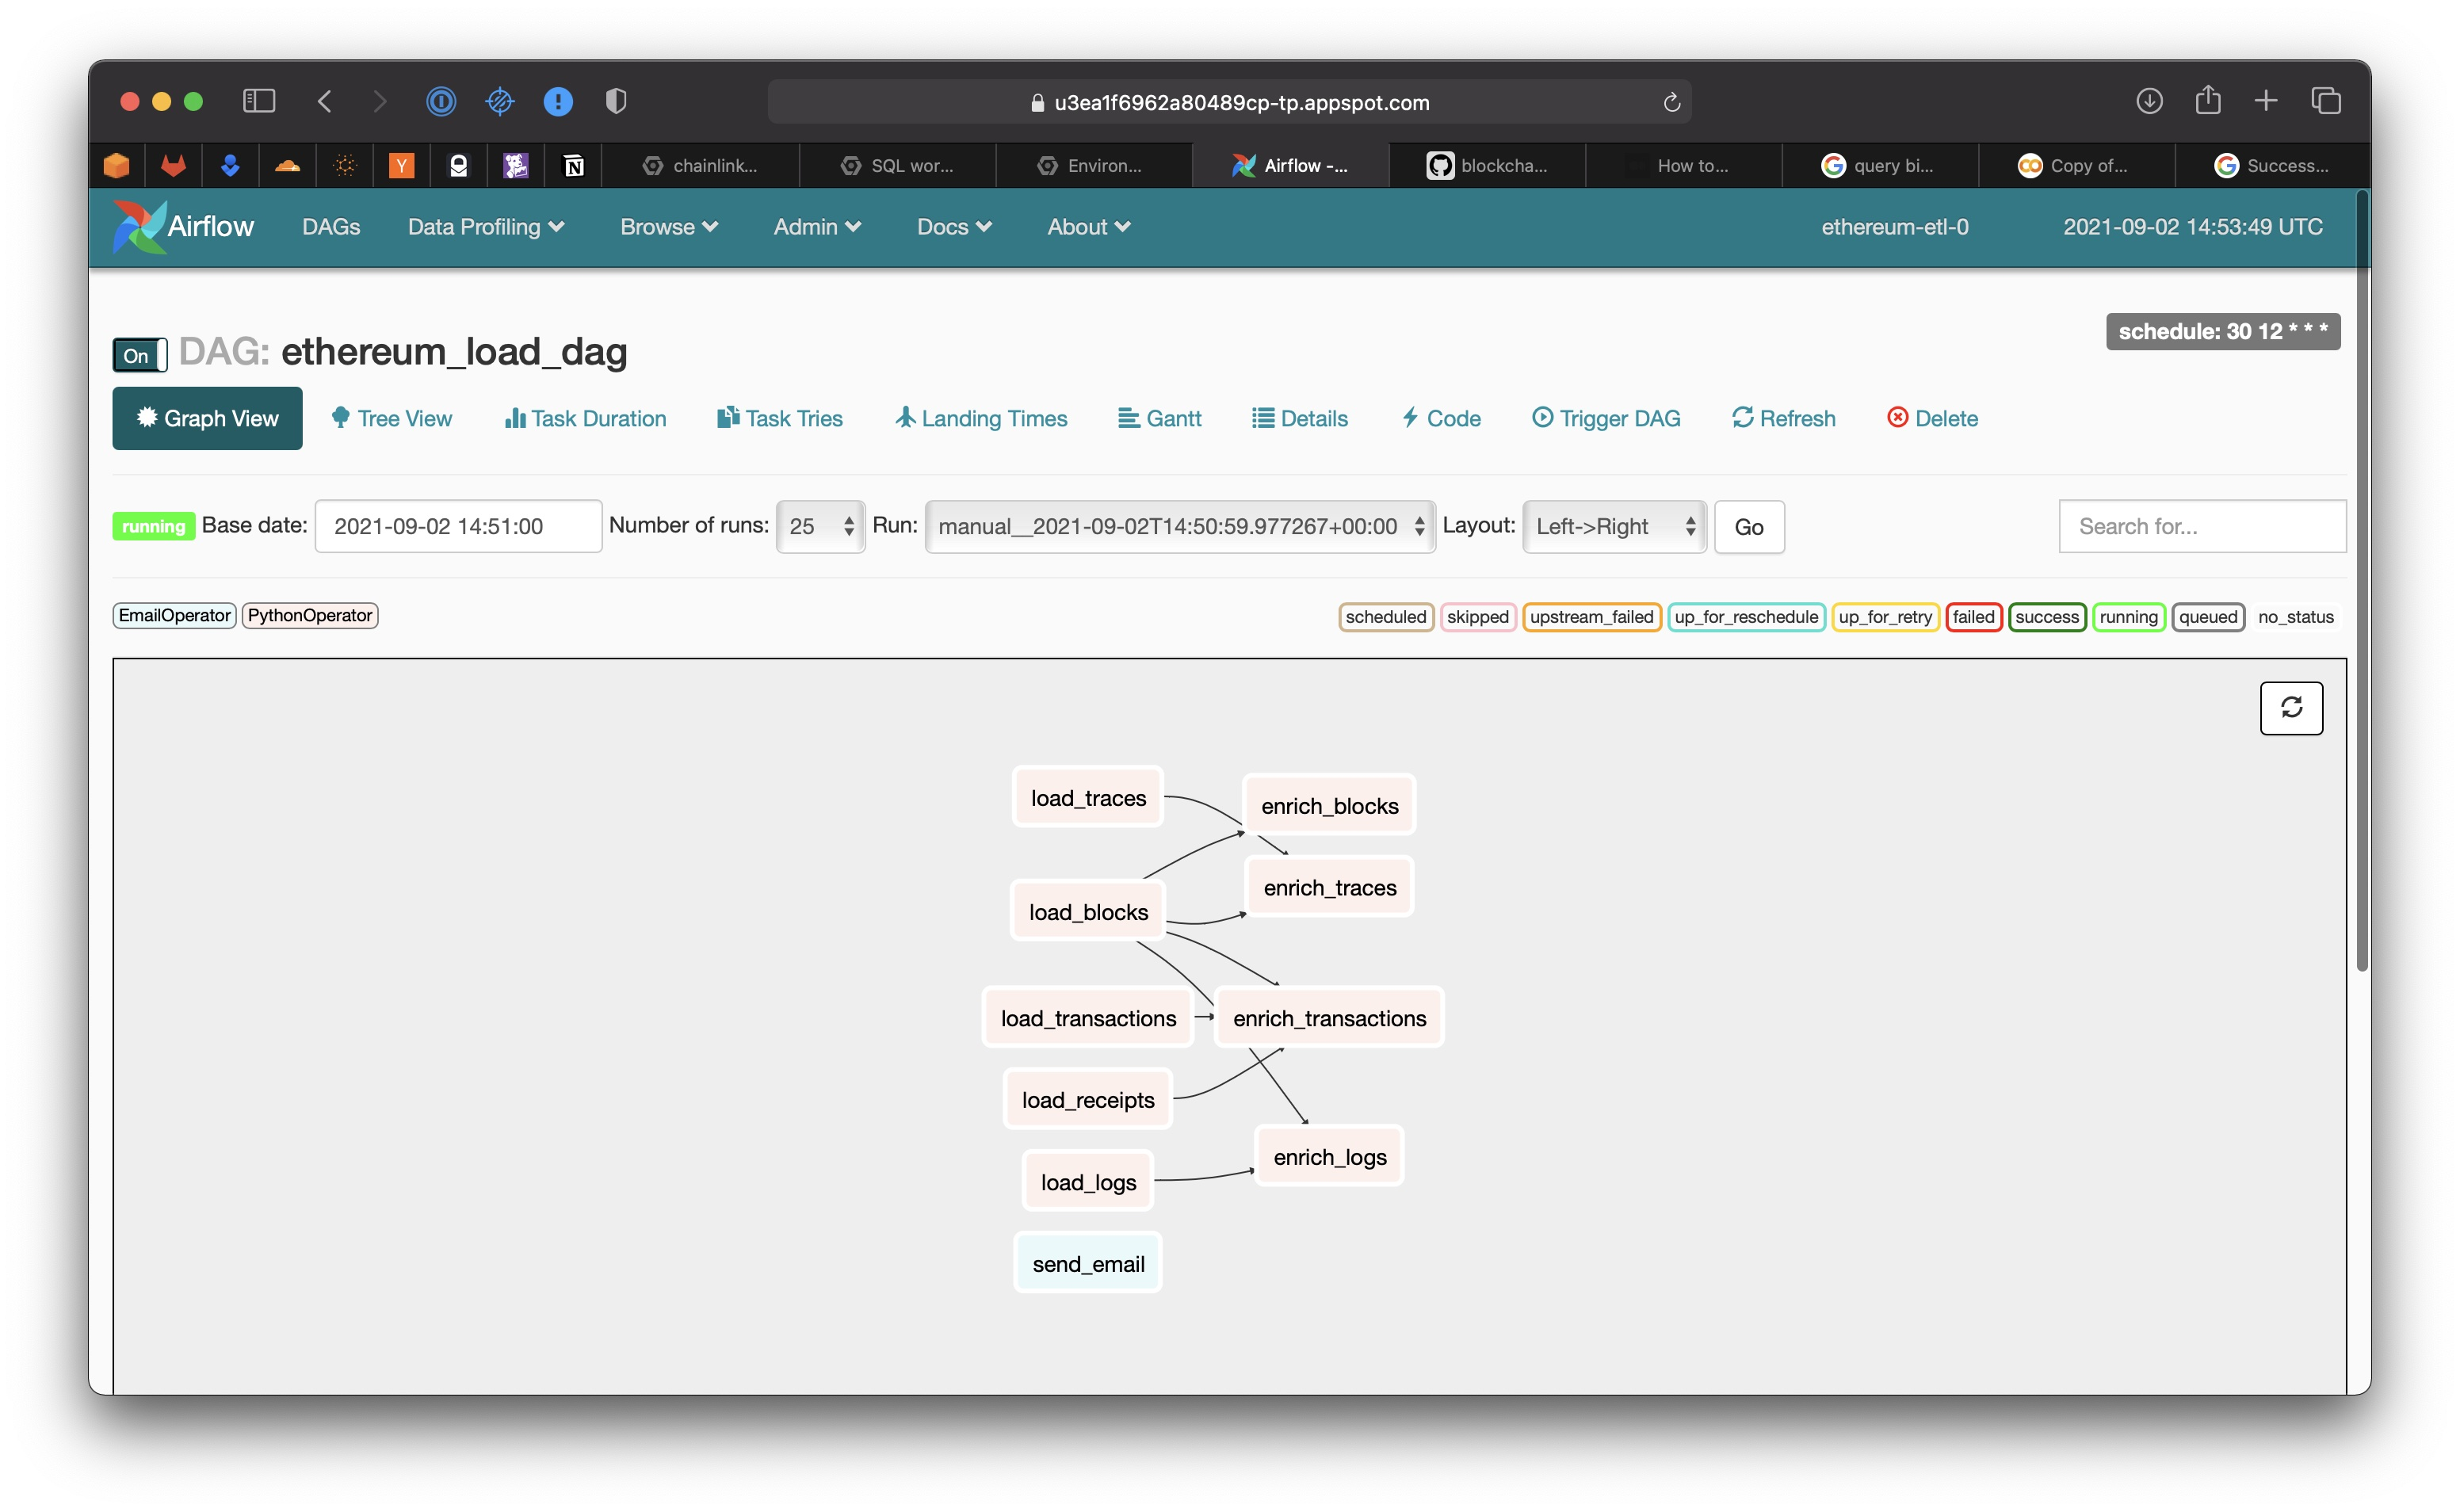

### Gantt chart

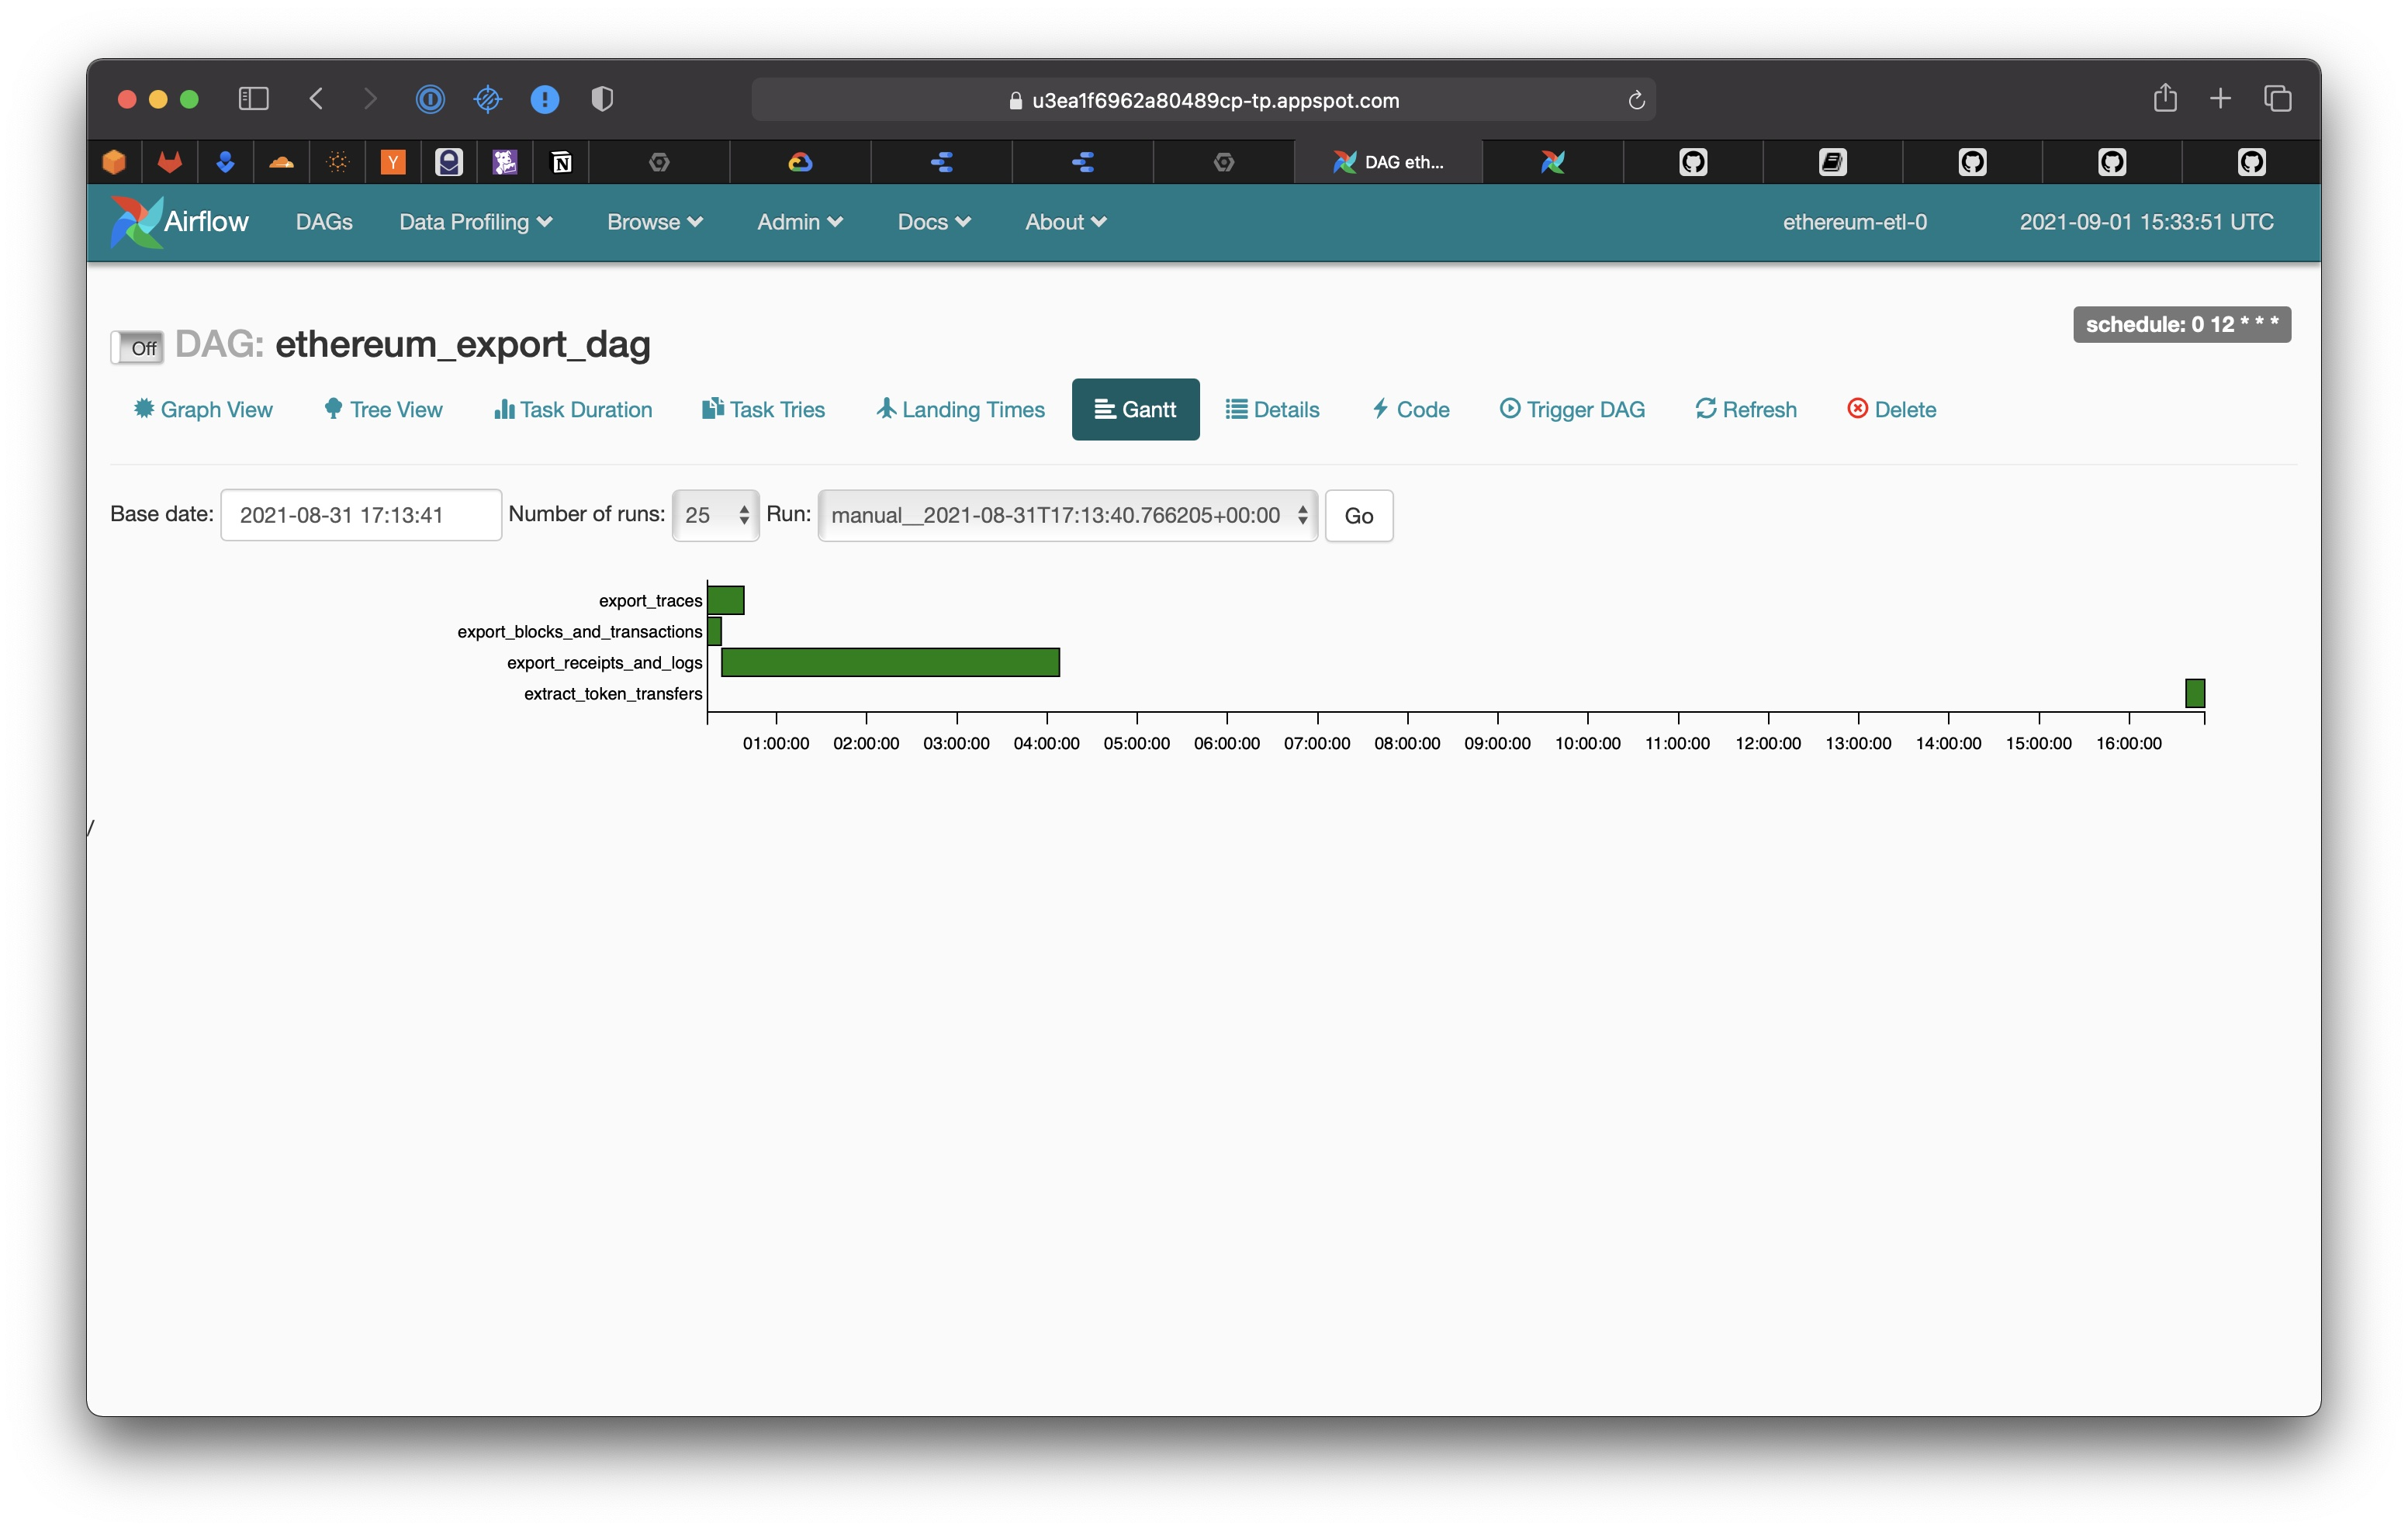

## Once the data has been loaded into BigQuery, we can interact with it using google-cloud-bigquery

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%load_ext google.colab.data_table

In [15]:
project_id = 'chainlink-demo-324915'

In [16]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

### Example of a basic query

In [17]:
df = client.query('''
  SELECT *
  FROM `chainlink-demo-324915.ethereum.blocks`
  LIMIT 20
  ''').to_dataframe()

In [18]:
df.head()

timestamp   number  ... transaction_count base_fee_per_gas
0 2020-02-19 23:27:37+00:00  9516640  ...                66             None
1 2020-02-19 17:11:49+00:00  9514938  ...               196             None
2 2020-02-19 20:49:37+00:00  9515919  ...                38             None
3 2020-02-19 08:00:30+00:00  9512443  ...               152             None
4 2020-02-19 17:58:11+00:00  9515164  ...                81             None

[5 rows x 19 columns]

### Example of a more advanced query

In [19]:
# source: https://medium.com/google-cloud/how-to-query-balances-for-all-ethereum-addresses-in-bigquery-fb594e4034a7
query = """
    with double_entry_book as (
        -- debits
        select to_address as address, value as value
        from `chainlink-demo-324915.ethereum.traces`
        where to_address is not null
        and status = 1
        and (call_type not in ('delegatecall', 'callcode', 'staticcall') or call_type is null)
        union all
        -- credits
        select from_address as address, -value as value
        from `chainlink-demo-324915.ethereum.traces`
        where from_address is not null
        and status = 1
        and (call_type not in ('delegatecall', 'callcode', 'staticcall') or call_type is null)
        union all
        -- transaction fees debits
        select 
            miner as address, 
            sum(cast(receipt_gas_used as numeric) * cast((receipt_effective_gas_price - coalesce(base_fee_per_gas, 0)) as numeric)) as value
        from `chainlink-demo-324915.ethereum.transactions` as transactions
        join `chainlink-demo-324915.ethereum.blocks` as blocks on blocks.number = transactions.block_number
        group by blocks.number, blocks.miner
        union all
        -- transaction fees credits
        select 
            from_address as address, 
            -(cast(receipt_gas_used as numeric) * cast(receipt_effective_gas_price as numeric)) as value
        from `chainlink-demo-324915.ethereum.transactions`
    )
    select address, sum(value) as balance
    from double_entry_book
    group by address
    order by balance desc
    limit 100
"""

top_balances = client.query(query)

In [23]:
df = top_balances.to_dataframe()
df

address                    balance
0   0x00000000219ab540356cbb839cbe05303d7705fa  7390370000069000000000069
1   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2  6924329980297011630354850
2   0xbe0eb53f46cd790cd13851d5eff43d12404d33e8  2296896492485353896863048
3   0x73bceb1cd57c711feac4224d062b0f6ff338501e  1919046615034293881366027
4   0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5  1794424757452616496376938
..                                         ...                        ...
95  0x0c05ec4db907cfb91b2a1a29e7b86688b7568a6d   150000000000000000000000
96  0x091933ee1088cdf5daace8baec0997a4e93f0dd6   150000000000000000000000
97  0xa0efb63be0db8fc11681a598bf351a42a6ff50e0   150000000000000000000000
98  0x9cf36e93a8e2b1eaaa779d9965f46c90b820048c   150000000000000000000000
99  0x4756eeebf378046f8dd3cb6fa908d93bfd45f139   150000000000000000000000

[100 rows x 2 columns]

# Part 2: Creating visualizations with Data Studio

### [Link to Data Studio project](https://datastudio.google.com/reporting/d9061c36-6372-4e90-b995-c88fd8da2787)

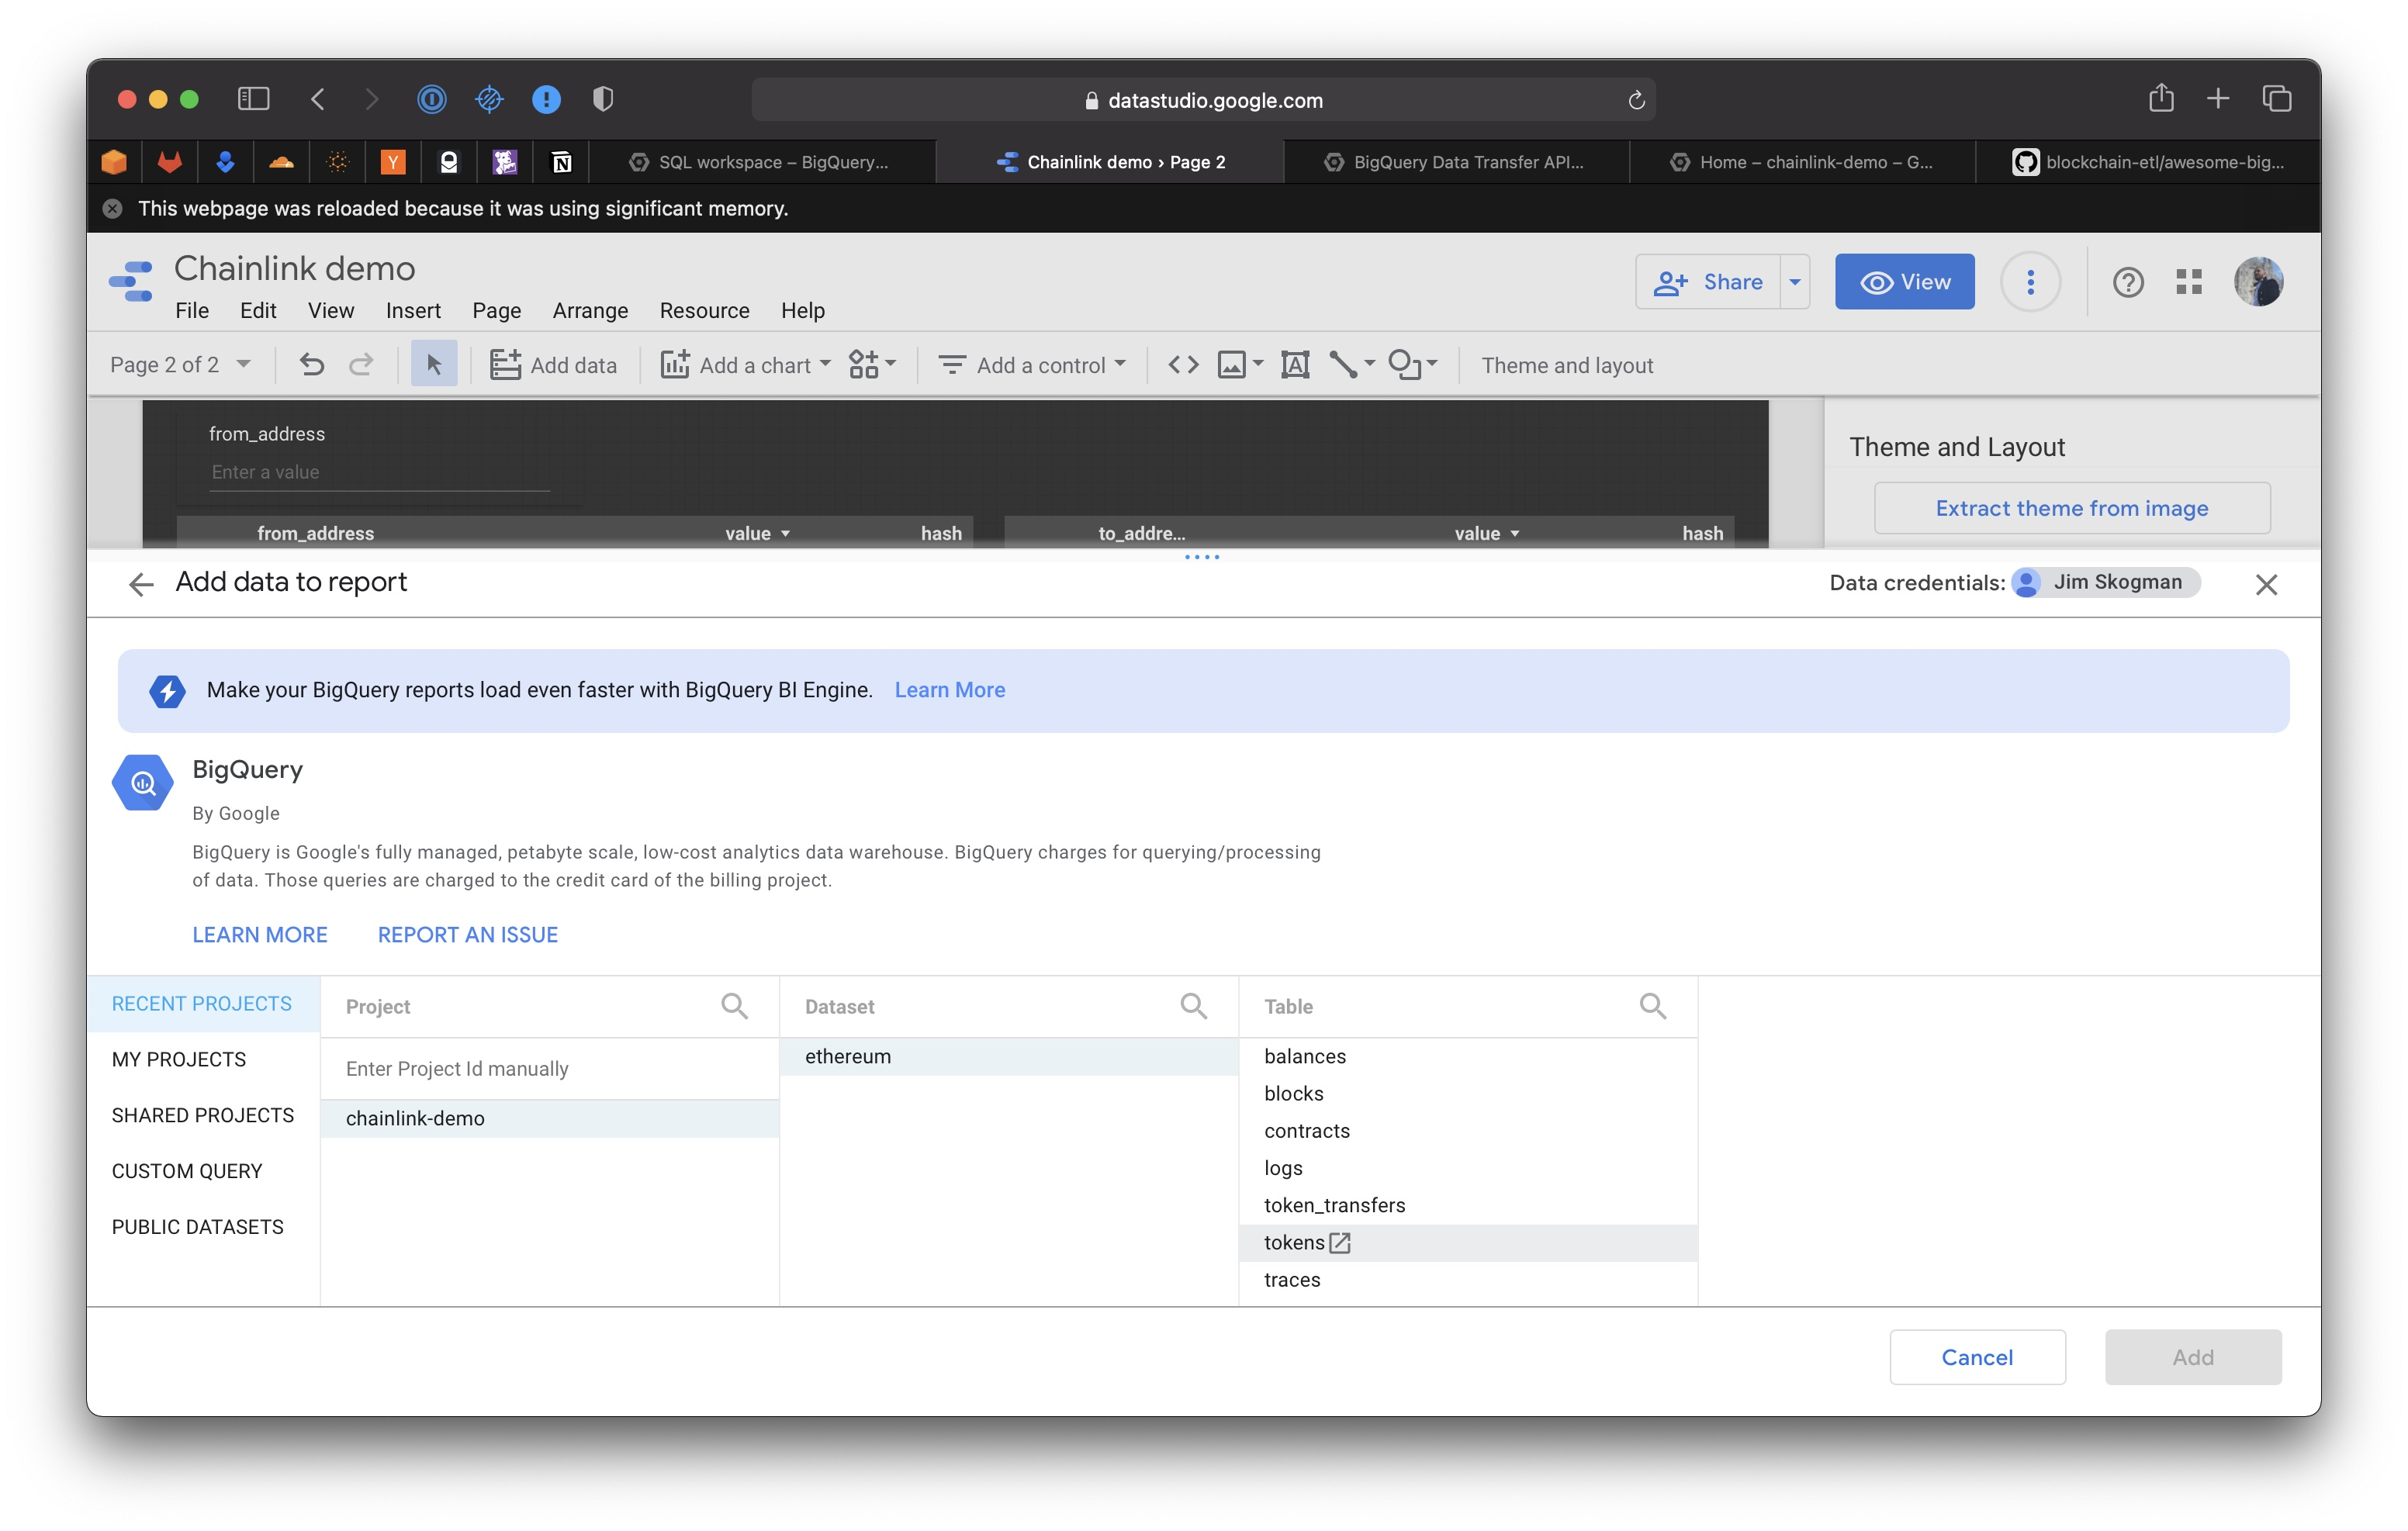

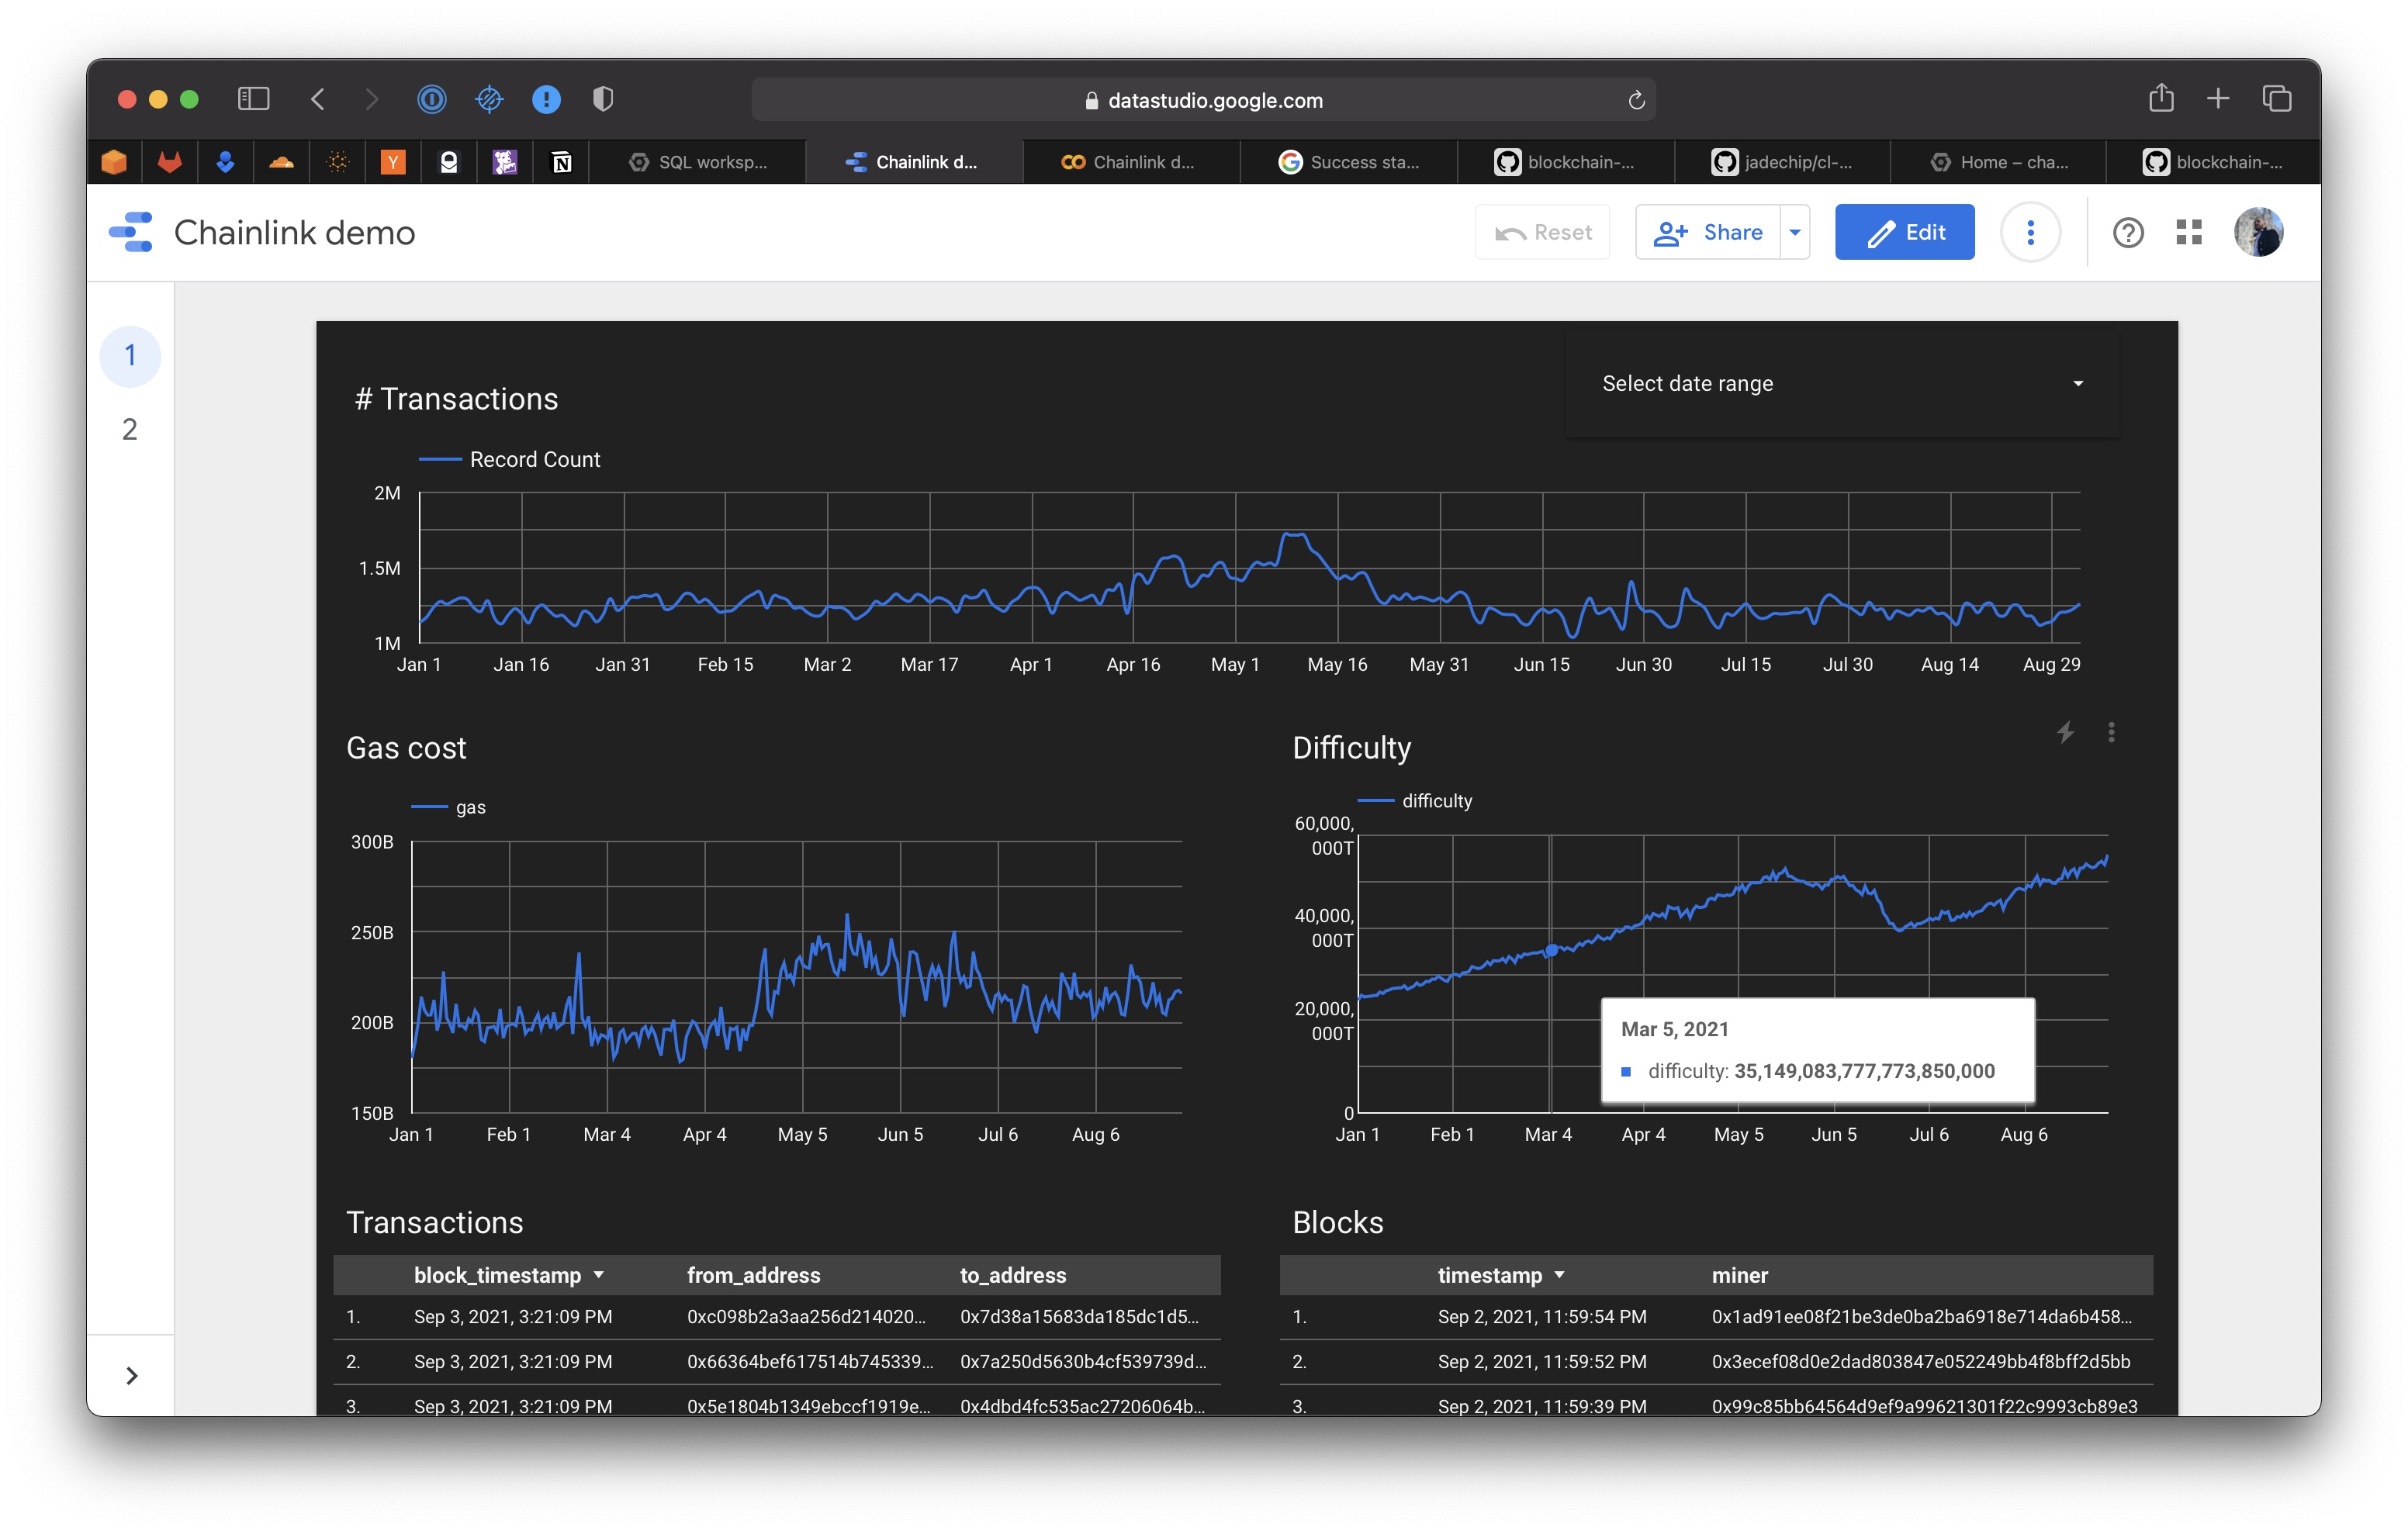

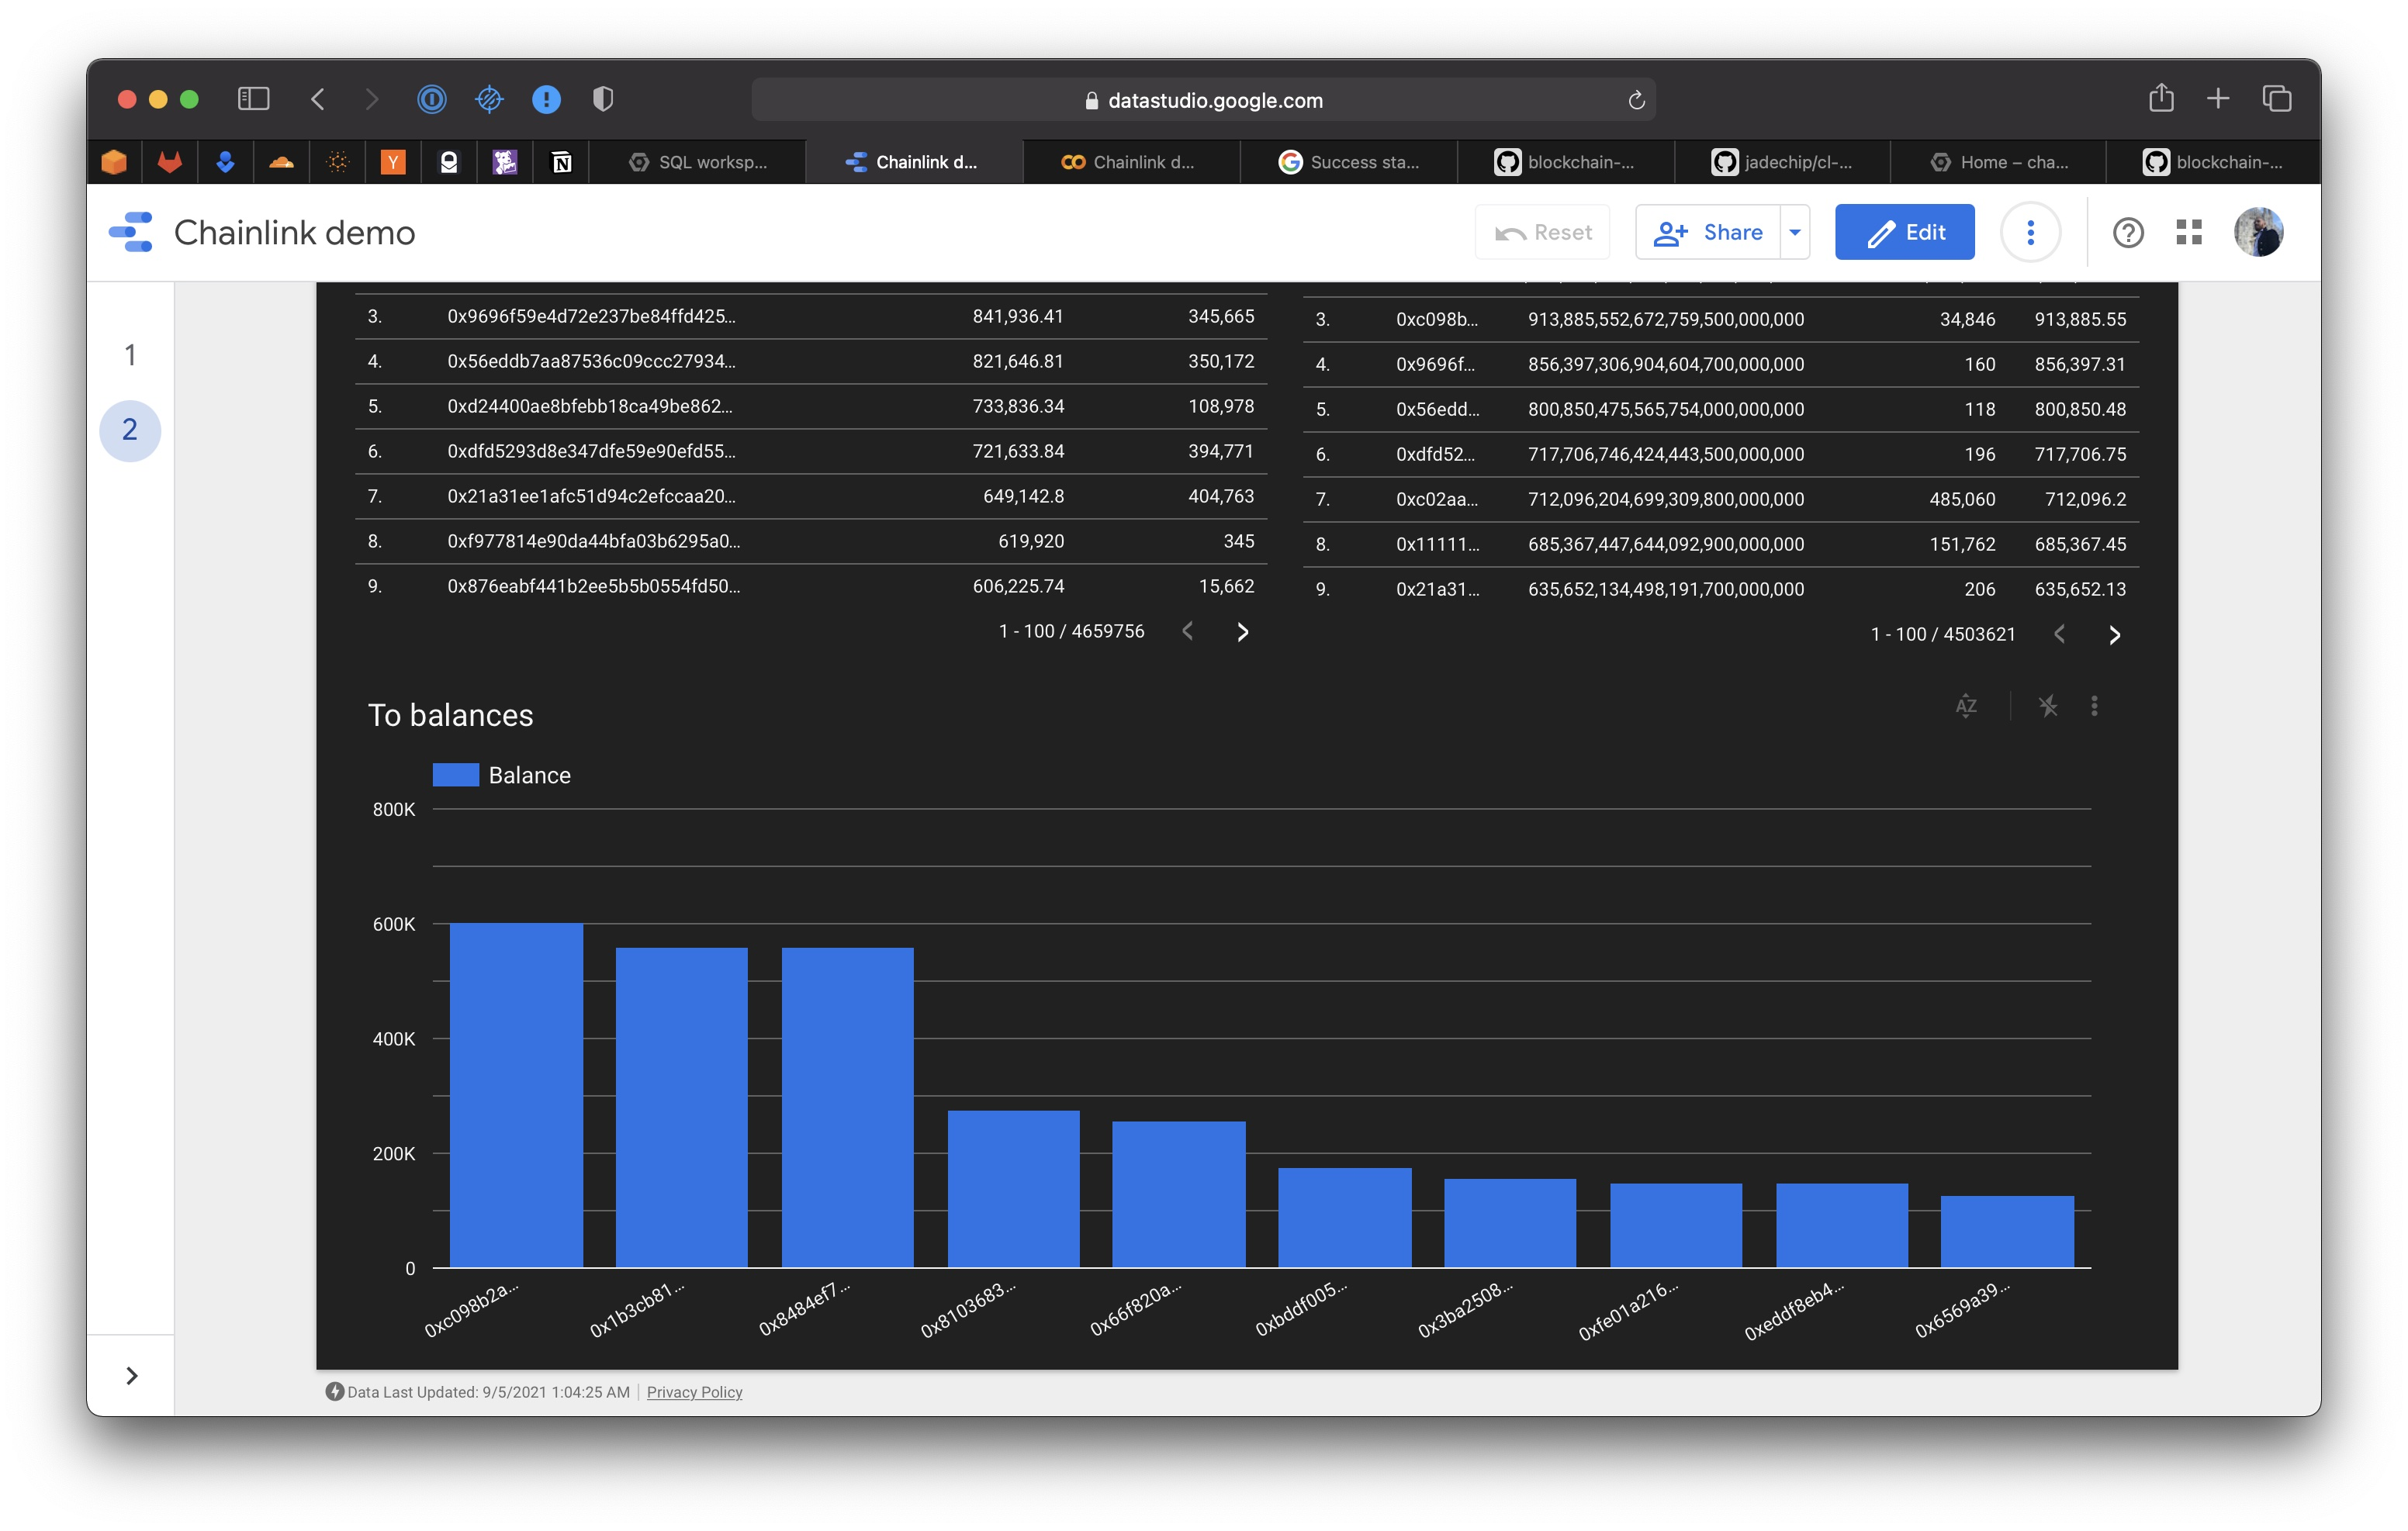

### [Link to Data Studio project](https://datastudio.google.com/reporting/d9061c36-6372-4e90-b995-c88fd8da2787)

# Part 3: Prediction model

Here I download onchain data and metrics from Glassnode & Coinmetrics to train a time series prediction model using Pytorch.

In [107]:
import io
import json
import requests
import functools
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

In [108]:
def make_request(url, *args):
  print(url(*args))
  return requests.get(url(*args))

In [109]:
start      = 20100718
end        = 20180429
params     = "PriceUSD"
url        = lambda params: f"https://community-api.coinmetrics.io/v2/assets/btc/metricdata?metrics={params}&start={start}&end={end}"

In [110]:
response = make_request(url, "PriceUSD")

https://community-api.coinmetrics.io/v2/assets/btc/metricdata?metrics=PriceUSD&start=20100718&end=20180429


In [111]:
json = response.json()
price_df = pd.DataFrame(json["metricData"]["series"])
price_df["values"] = price_df["values"].apply(lambda x: x[0])
price_df["values"] = price_df["values"].astype(float)
price_df['time'] = pd.to_datetime(price_df['time'])
price_df['time'] = price_df['time'].dt.strftime('%d-%m-%Y')
price_df.head()

time    values
0  18-07-2010  0.085840
1  19-07-2010  0.080800
2  20-07-2010  0.074736
3  21-07-2010  0.079193
4  22-07-2010  0.058470

In [156]:
start      = 1279324800
end        = 1524960000
metrics_df = pd.DataFrame()
api_key    = "5a0cf8d7-d14a-44f4-b063-a76807cd5340"
base       = "https://api.glassnode.com/v1"
url        = lambda api_key: f"{endpoint}?api_key={api_key}&a=BTC&s={start}&u={end}"
endpoints  = {
  "new_addresses"  : f"{base}/metrics/addresses/new_non_zero_count",
  "puell_multiple" : f"{base}/metrics/indicators/puell_multiple",
  "asopr"          : f"{base}/metrics/indicators/sopr_adjusted",
  "nvts"           : f"{base}/metrics/indicators/nvts",
  "cdd"           : f"{base}/metrics/indicators/cdd",
  "marketcap"      : f"{base}/metrics/market/marketcap_usd",
  "mvrv"           : f"{base}/metrics/market/mvrv",
}

In [157]:
for name, endpoint in endpoints.items():
  response = make_request(url, api_key)
  tmp = pd.read_json(response.content, convert_dates=["t"], date_unit="s")
  tmp.columns = ["date", name]
  diff = tmp.columns.difference(metrics_df.columns)
  metrics_df = pd.concat([metrics_df, tmp[diff]], axis=1, sort=False)

https://api.glassnode.com/v1/metrics/addresses/new_non_zero_count?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/puell_multiple?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/sopr_adjusted?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/nvts?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/cdd?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/market/marketcap_usd?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/market/mvrv?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000


In [158]:
metrics_df["price"] = price_df["values"]
metrics_df = metrics_df.set_index("date", drop=True)

metrics_df["asopr"].fillna(metrics_df["asopr"].mean(), inplace=True)
metrics_df["puell_multiple"].fillna(metrics_df["puell_multiple"].mean(), inplace=True)
metrics_df.head()

new_addresses  puell_multiple  ...      mvrv     price
date                                       ...                    
2010-07-17            447        3.656330  ...  1.000000  0.085840
2010-07-18            467        3.830945  ...  1.300600  0.080800
2010-07-19            605        3.691357  ...  1.814750  0.074736
2010-07-20            674        3.244558  ...  1.586253  0.079193
2010-07-21            469        3.366804  ...  1.399411  0.058470

[5 rows x 8 columns]

### Test-Training split

In [159]:
training_data, validation_data = train_test_split(metrics_df, test_size=0.2, shuffle=False)
validation_data, testing_data = train_test_split(validation_data, test_size=0.5, shuffle=False)

print(f"Training data size: {training_data.shape}",
      f"Validation data size: {validation_data.shape}",
      f"Testing data size: {testing_data.shape}")

Training data size: (2274, 8) Validation data size: (284, 8) Testing data size: (285, 8)


In [160]:
def compute_ma(series, window=90):
  return series.rolling(window=window).mean()

In [161]:
training_data["cdd"] = compute_ma(training_data["cdd"])
training_data["asopr"] = compute_ma(training_data["asopr"])

training_data['cdd'].fillna(value=training_data['cdd'].mean(), inplace=True)
training_data['asopr'].fillna(value=training_data['asopr'].mean(), inplace=True)

In [162]:
normalize = lambda df: (df - df.mean()) / (df.max() - df.min())

In [163]:
training_data = normalize(training_data)
validation_data = normalize(validation_data)
testing_data = normalize(testing_data)

In [164]:
training_data.head()

new_addresses  puell_multiple  ...      mvrv     price
date                                       ...                    
2010-07-17      -0.237017        0.215226  ... -0.113374 -0.197668
2010-07-18      -0.236958        0.232892  ... -0.068649 -0.197673
2010-07-19      -0.236547        0.218770  ...  0.007847 -0.197678
2010-07-20      -0.236342        0.173567  ... -0.026149 -0.197674
2010-07-21      -0.236952        0.185935  ... -0.053948 -0.197692

[5 rows x 8 columns]

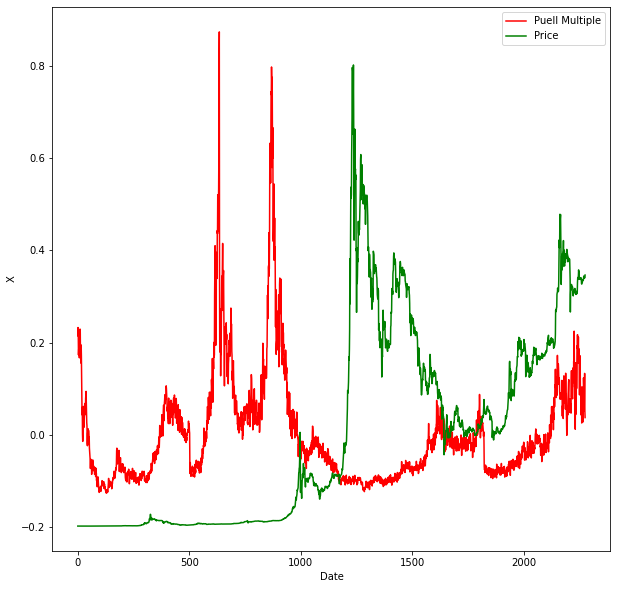

In [165]:
plt.figure(figsize=(10, 10))
epoch_count = range(1, len(training_data) + 1)
plt.plot(epoch_count, training_data["puell_multiple"], 'red')
plt.plot(epoch_count, training_data["price"], 'green')
plt.legend(["Puell Multiple", "Price"])
plt.xlabel('Date')
plt.ylabel('X')
plt.show()

### Hyperparameters

In [166]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision import datasets, models, transforms

In [167]:
EPOCHS        = 1000
DROPOUT       = 0.2
DIRECTIONS    = 1
NUM_LAYERS    = 2
BATCH_SIZE    = 5
OUTPUT_SIZE   = 1
SEQ_LENGTH    = 30
NUM_FEATURES  = 6
HIDDEN_SIZE   = 100
LEARNING_RATE = 0.001
STATE_DIM     = NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE

In [168]:
class OnchainDataset(Dataset):
    """Onchain dataset."""

    def __init__(self, csv_file, seq_length):
        """
        Args:
        """
        self.csv_file = csv_file
        self.target = "price"

        self.features = ["new_addresses", "puell_multiple", "asopr", "nvts", "marketcap", "mvrv"] 
        self.seq_length = seq_length
        self.data_length = len(csv_file)

        self.metrics = self.create_xy_pairs()

    def create_xy_pairs(self):
        pairs = []
        for idx in range(self.data_length - self.seq_length):
            x = self.csv_file[idx:idx + self.seq_length][self.features].values
            y = self.csv_file[idx + self.seq_length:idx + self.seq_length + 1][self.target].values
            pairs.append((x, y))
        return pairs

    def __len__(self):
        return len(self.metrics)

    def __getitem__(self, idx):
        return self.metrics[idx]

In [169]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': False,
          'drop_last': True, # Disregard last incomplete batch
          'num_workers': 4}

params_test = {'batch_size': 1,
          'shuffle': False,
          'drop_last': False, # Disregard last incomplete batch
          'num_workers': 4}

training_ds = OnchainDataset(training_data, SEQ_LENGTH)
training_dl = DataLoader(training_ds, **params)

validation_ds = OnchainDataset(validation_data, SEQ_LENGTH)
validation_dl = DataLoader(validation_ds, **params)

testing_ds = OnchainDataset(testing_data, SEQ_LENGTH)
testing_dl = DataLoader(testing_ds, **params_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [170]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [171]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, directions=1):
    super(LSTM, self).__init__()

    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.directions = directions

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
    self.dropout = nn.Dropout(dropout_prob)
    self.linear = nn.Linear(hidden_size, output_size)

  def init_hidden_states(self, batch_size):
    state_dim = (self.num_layers * self.directions, batch_size, self.hidden_size)
    return (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))

  def forward(self, x, states):
    x, (h, c) = self.lstm(x, states)
    out = self.linear(x)
    return out, (h, c)

In [172]:
model = LSTM(
    NUM_FEATURES,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

In [173]:
def save_checkpoint(epoch, min_val_loss, model_state, opt_state):
  print(f"New minimum reached at epoch #{epoch + 1}, saving model state...")
  checkpoint = {
    'epoch': epoch + 1,
    'min_val_loss': min_val_loss,
    'model_state': model_state,
    'opt_state': opt_state,
  }
  torch.save(checkpoint, "./model_state.pt")


def load_checkpoint(path, model, optimizer):
    # load check point
    checkpoint = torch.load(path)
    min_val_loss = checkpoint["min_val_loss"]
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["opt_state"])
    return model, optimizer, checkpoint["epoch"], min_val_loss


def training(model, epochs, validate_every=2):

  training_losses = []
  validation_losses = []

  min_validation_loss = np.Inf

  # Set to train mode
  model.train()

  for epoch in tqdm(range(epochs)):

    # Initialize hidden and cell states with dimension:
    # (num_layers * num_directions, batch, hidden_size)
    states = model.init_hidden_states(BATCH_SIZE)
    running_training_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(training_dl):
      # Convert to Tensors
      x_batch = x_batch.float().to(device)
      y_batch = y_batch.float().to(device)
      
      # Truncated Backpropagation
      states = [state.detach() for state in states]          

      optimizer.zero_grad()

      # Make prediction
      output, states = model(x_batch, states)

      # Calculate loss
      loss = criterion(output[:, -1, :], y_batch)
      loss.backward()
      running_training_loss += loss.item()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
        
    # Average loss across timesteps
    training_losses.append(running_training_loss / len(training_dl))
        
    if epoch % validate_every == 0:

      # Set to eval mode
      model.eval()

      validation_states = model.init_hidden_states(BATCH_SIZE)
      running_validation_loss = 0.0

      for idx, (x_batch, y_batch) in enumerate(validation_dl):

        # Convert to Tensors
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().to(device)
      
        validation_states = [state.detach() for state in validation_states]
        
        output, validation_states = model(x_batch, validation_states)
        validation_loss = criterion(output[:, -1, :], y_batch)
        running_validation_loss += validation_loss.item()
        
    validation_losses.append(running_validation_loss / len(validation_dl))
    # Reset to training mode
    model.train()

    is_best = running_validation_loss / len(validation_dl) < min_validation_loss

    if is_best:
      min_validation_loss = running_validation_loss / len(validation_dl)
      save_checkpoint(epoch + 1, min_validation_loss, model.state_dict(), optimizer.state_dict())
        

  # Visualize loss
  epoch_count = range(1, len(training_losses) + 1)
  plt.plot(epoch_count, training_losses, 'r--')
  plt.legend(['Training Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

  val_epoch_count = range(1, len(validation_losses) + 1)
  plt.plot(val_epoch_count, validation_losses, 'b--')
  plt.legend(['Validation loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()    

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  1%|          | 1/100 [00:08<14:41,  8.91s/it]

New minimum reached at epoch #2, saving model state...


  3%|▎         | 3/100 [00:26<14:09,  8.76s/it]

New minimum reached at epoch #4, saving model state...


  5%|▌         | 5/100 [00:43<13:48,  8.72s/it]

New minimum reached at epoch #6, saving model state...


  7%|▋         | 7/100 [01:00<13:26,  8.67s/it]

New minimum reached at epoch #8, saving model state...


  9%|▉         | 9/100 [01:18<13:11,  8.70s/it]

New minimum reached at epoch #10, saving model state...


 11%|█         | 11/100 [01:35<12:57,  8.74s/it]

New minimum reached at epoch #12, saving model state...


 13%|█▎        | 13/100 [01:52<12:34,  8.67s/it]

New minimum reached at epoch #14, saving model state...


 15%|█▌        | 15/100 [02:10<12:22,  8.74s/it]

New minimum reached at epoch #16, saving model state...


 17%|█▋        | 17/100 [02:27<12:14,  8.85s/it]

New minimum reached at epoch #18, saving model state...


 19%|█▉        | 19/100 [02:45<11:56,  8.85s/it]

New minimum reached at epoch #20, saving model state...


 21%|██        | 21/100 [03:03<11:40,  8.87s/it]

New minimum reached at epoch #22, saving model state...


 23%|██▎       | 23/100 [03:21<11:27,  8.93s/it]

New minimum reached at epoch #24, saving model state...


 25%|██▌       | 25/100 [03:38<11:08,  8.91s/it]

New minimum reached at epoch #26, saving model state...


 27%|██▋       | 27/100 [03:56<10:49,  8.90s/it]

New minimum reached at epoch #28, saving model state...


 29%|██▉       | 29/100 [04:14<10:30,  8.88s/it]

New minimum reached at epoch #30, saving model state...


 31%|███       | 31/100 [04:31<10:13,  8.89s/it]

New minimum reached at epoch #32, saving model state...


 33%|███▎      | 33/100 [04:49<09:53,  8.85s/it]

New minimum reached at epoch #34, saving model state...


 35%|███▌      | 35/100 [05:06<09:33,  8.82s/it]

New minimum reached at epoch #36, saving model state...


 37%|███▋      | 37/100 [05:24<09:21,  8.91s/it]

New minimum reached at epoch #38, saving model state...


 39%|███▉      | 39/100 [05:42<08:59,  8.85s/it]

New minimum reached at epoch #40, saving model state...


 41%|████      | 41/100 [05:59<08:38,  8.79s/it]

New minimum reached at epoch #42, saving model state...


 43%|████▎     | 43/100 [06:17<08:22,  8.82s/it]

New minimum reached at epoch #44, saving model state...


 45%|████▌     | 45/100 [06:34<08:06,  8.85s/it]

New minimum reached at epoch #46, saving model state...


 47%|████▋     | 47/100 [06:52<07:48,  8.84s/it]

New minimum reached at epoch #48, saving model state...


 49%|████▉     | 49/100 [07:09<07:27,  8.77s/it]

New minimum reached at epoch #50, saving model state...


 51%|█████     | 51/100 [07:27<07:10,  8.79s/it]

New minimum reached at epoch #52, saving model state...


 59%|█████▉    | 59/100 [08:37<06:03,  8.88s/it]

New minimum reached at epoch #60, saving model state...


 61%|██████    | 61/100 [08:55<05:44,  8.83s/it]

New minimum reached at epoch #62, saving model state...


 67%|██████▋   | 67/100 [09:47<04:51,  8.82s/it]

New minimum reached at epoch #68, saving model state...


 75%|███████▌  | 75/100 [10:57<03:41,  8.87s/it]

New minimum reached at epoch #76, saving model state...


 77%|███████▋  | 77/100 [11:15<03:23,  8.87s/it]

New minimum reached at epoch #78, saving model state...


 79%|███████▉  | 79/100 [11:33<03:06,  8.88s/it]

New minimum reached at epoch #80, saving model state...


 81%|████████  | 81/100 [11:50<02:48,  8.88s/it]

New minimum reached at epoch #82, saving model state...


 89%|████████▉ | 89/100 [13:00<01:36,  8.75s/it]

New minimum reached at epoch #90, saving model state...


 91%|█████████ | 91/100 [13:18<01:18,  8.77s/it]

New minimum reached at epoch #92, saving model state...


100%|██████████| 100/100 [14:35<00:00,  8.76s/it]


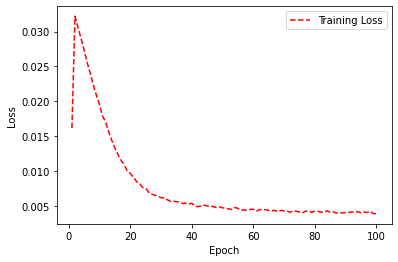

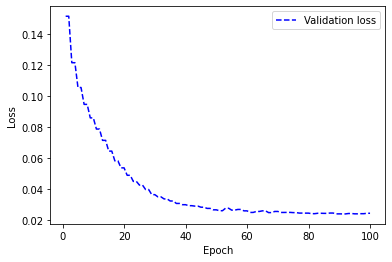

In [174]:
training(model, 100)

In [175]:
path = "./model_state.pt"
model, optimizer, start_epoch, valid_loss_min = load_checkpoint(path, model, optimizer)
print("model = ", model)
print("optimizer = ", optimizer)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))

model =  LSTM(
  (lstm): LSTM(6, 100, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
optimizer =  AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
start_epoch =  92
valid_loss_min =  0.023828430811408906
valid_loss_min = 0.023828
